## LISA PE with TaylorF2

In [1]:
# Import packages that you may already have pip installed in your environment.

import sys
import scipy
import numpy as np
import matplotlib.pyplot as plt
import time
from math import *
from scipy import signal
import os
import warnings

# Import other packages which are less common and specific to the task at hand.

from functions import *
import emcee
import corner
import multiprocessing as mp
import matplotlib.patches as mpatches

# Initialize random number generator.
np.random.seed(12345)

### Generate toy signals in the time and frequency domains

Here we define the TaylorF2 approximant up to 3.5PN contributions.
References for TaylorF2 models

- https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)]
- https://arxiv.org/pdf/0907.0700.pdf [Eqs.(3.17)-(3.18)]

In [2]:
# Bunch of units

pc= 3.0856776*1e16
M_sun =1.9884099*1e30
Mpc = 10**6 * pc

In [3]:
def htilde(f,params):
    
    """
    Here we calculate a TaylorF2 model up to 2PN which takes as input the following
    set of parameters: (log of chirp mass, symmetric mass ratio, beta).
    This can easily be changed in the first few lines where the parameters are loaded.
    The main reference is https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)].
    
    Note on distance: 
    
    Notice that the effective distance contains information about the angular dependence
    of the binary. The model can thus be used for all detectors, as long as this distance
    parameter is chosen consistently. 
    
    Note on spin: 
    
    The spin parameter beta is defined in Eq.(2.3a) in [arxiv:0411129].
    Notice that this quantity is constructed in such a way to be smaller or equal
    than 9.4, and of course it ranges from 0 (no spins) to this upper value. 
    The coefficient enters the phase as in Eq.(2.2) in the same paper.
    """
    # Units
    
    GM_sun = 1.3271244*1e20
    c =2.9979246*1e8
    M_sun =1.9884099*1e30
    G = 6.6743*1e-11
    pc= 3.0856776*1e16
    pi = np.pi
    Mpc = 10**6 * pc
    
    # Load the parameters
    Mchirp_true = np.exp(params[0])
    eta_true = params[1]
    beta_true = params[2]
    
    # PN expansion parameter (velocity).
    v = (pi*G*Mchirp_true*eta_true**(-3/5)/(c**3) * f)**(1/3)
    
    # Amplitude explicitly given in terms of units and frequency.
    # Notice that lowest PN order here is fine. Biggest contributions from phase.
    amplitude_1 = - (Mpc/Deff)*np.sqrt((5/(24*pi)))*(GM_sun/(c**2 *Mpc))
    amplitude_2 = (pi*GM_sun/(c**3))**(-1/6) * (Mchirp_true/M_sun)**(5/6)
    amplitude = amplitude_1*amplitude_2 * f**(-7/6)
    
    # Phase: add or remove PN orders here as you see fit.
    psi_const = 2*pi*f*t0 - 2*phi0 - pi/4
    psi1PN = (3715/756+55/9*eta_true)*v**(-3)
    psi1_5PN = (-16*pi+4*beta_true)*v**(-2)
    psi2PN = (15293365/508032+27145/504*eta_true+3085/72*eta_true**2)*v**(-1)

    psi_fullPN = 3/(128*eta_true)*(v**(-5)+psi1PN+psi1_5PN+psi2PN)
    psi = psi_const + psi_fullPN 
    
    return amplitude* np.exp(1j*psi)

def T_chirp(fmin,M_chirp,eta):
    
    """
    Function to give time at chirp from an initial frequency. 
    Used to pick out the total observation time. 
    """
    
    M = M_chirp*eta**(-3/5)
    v_low = (pi*G*M_chirp*eta**(-3/5)/(c**3) * fmin)**(1/3)
    
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    gamma = np.euler_gamma
    
    pre_fact = ((5/(256*eta)) * G*M/(c**3))
    first_term = (v_low**(-8) + (743/252 + (11/3) * eta ) * (v_low **(-6)) - (32*np.pi/5)*v_low**(-5)
                +(3058673/508032 + (5429/504)*eta + (617/72)*eta**2)*v_low**(-4)
                 +(13*eta/3 - 7729/252)*np.pi*v_low**-3)
    
    second_term = (6848*gamma/105 - 10052469856691/23471078400 + 128*pi**2/3 + (
    3147553127/3048192 - 451*(pi**2)/12)*eta - (15211*eta**2)/1728 + (2555*eta**3 / 1296) +
                   (6848/105)*np.log(4*v_low))*v_low**-2
    
    third_term = ((14809/378)*eta**2 - (75703/756) * eta - 15419335/127008)*pi*v_low**-1
    return pre_fact * (first_term + second_term + third_term)

Input some true parameters for the true signal.

In [4]:
"""
Reference signal parameters
"""

# Fix these two impostors, assume they are known perfectly.
t0 =0.
phi0 =0.

# Find a resonable distance for the signal 

Deff = 10**3 *Mpc
logDeff = np.log(Deff)

beta_true = 5.0
eta_true = 0.2
mtot = 2*1e6 #in solar masses
Mchirp = mtot*(eta_true)**(3/5)
Mchirp_true =Mchirp* M_sun
logMchirp_true = np.log(Mchirp_true)

pars = [logMchirp_true,eta_true,beta_true] # array of parameters to sample through

Here we set up the signal in the time and frequency domain.
Notice that we take the observation time to be the chirp time as if the black-hole binaries were Scharzschild.

In [5]:
"""
Frequency domain
"""
fmin =  0.0004
fmax =  c**3/(6*np.sqrt(6)*pi*G*Mchirp_true *eta_true**(-3/5))
t_year = 365*24*60*60       


T_obs = T_chirp(fmin,Mchirp_true,eta_true)  # Take signal in seconds.


delta_f =1/T_obs
freq = np.arange(fmin,fmax,delta_f)

print('df:', delta_f)
print('We observe for',
      np.round(T_obs,1),'s, ',
      np.round(12*30*T_obs/t_year,1),'days, ',
      np.round(T_obs/t_year,4),'yr')
print('fmin:', fmin)
print('fmax (chirp):', fmax)
print('Length of frequency array:', len(freq))

df: 9.270909849533843e-06
We observe for 107864.3 s,  1.2 days,  0.0034 yr
fmin: 0.0004
fmax (chirp): 0.0021991474891672074
Length of frequency array: 195


Next, we build up noise. We use Parseval's theorem to calculate the noise. This amounts to using the following variance

$$
\sigma^2_n= \frac{S_n}{4 dt} N_t
$$

where:

- $\sigma^2$ is the noise variance.
- $S_n$ is the detector's PSD.
- $dt$ is the sampling interval.
- $N_t$ is the length of the (padded) signal.

**Notice**: in this case, we do not consider confusion noise from white-dwarf binaries. This can be changed if needed.

In [6]:
def PowerSpectralDensity(f):
    """
    @Ollie Burke
    
    Power Spectral Density for the LISA detector assuming it has been active for a year. 
    I found an analytic version in one of Niel Cornish's paper which he submitted to the arXiv in
    2018. I evaluate the PSD at the frequency bins found in the signal FFT.
    
    PSD obtained from: https://arxiv.org/pdf/1803.01944.pdf.
    Values chosen for confusion noise after 1 year of observation.
    
    """
    
    sky_averaging_constant = 1.0
    L = 2.5*10**9   # Length of LISA arm
    f0 = 19.09*10**(-3)    

    Poms = ((1.5e-11)*(1.5e-11))*(1 + np.power((2e-3)/f, 4))  # Optical Metrology Sensor
    Pacc = (3e-15)*(3e-15)* (1 + (4e-4/f)*(4e-4/f))*(1 + np.power(f/(8e-3),4 ))  # Acceleration Noise
    
    # Parameters for confusion noise after Tobs=1yr.
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    
    Sc = 0 # no confusion noise (non-stationary effect)
           # add it back here, in case.

    PSD = sky_averaging_constant* ((10/(3*L*L))*(Poms + (4*Pacc)/(np.power(2*np.pi*f,4)))*(1 + 0.6*(f/f0)*(f/f0)) + Sc) # PSD

    return PSD

In [7]:
PSD = PowerSpectralDensity(freq)

noisevar = PSD/(4*delta_f)                   # Parseval's theorem
noisemean = 0. 

Finally, set up the data in the frequency domain. Add noise, extra signals etc. as you please, here. I warn against it.

In [8]:
# signals
h_true_vec_f = htilde(freq,pars)
data_f_vec = h_true_vec_f

And finally we calculate the SNRs.

In [9]:
def inner_prod(sig1_f,sig2_f,PSD,delta_f):
    """
    Only makes sense for continuous fourier transforms. (No dt's floating around). 
    This takes as input dimensionful quantities.
    """
    return (4*delta_f) * np.real(np.sum(np.conjugate(sig1_f)*sig2_f/PSD))

In [10]:
# SNR of the resolved source

SNR2 = inner_prod(data_f_vec,h_true_vec_f,PSD,delta_f) 
h_SNR2 = inner_prod(h_true_vec_f,h_true_vec_f,PSD,delta_f) 

rho = np.sqrt(SNR2)
print('Optimal SNR for the resolved source is',rho)

Optimal SNR for the resolved source is 16891.35896376206


### Setting up the MCMC

Here we setup the MCMC check. First of all we write down the priors.

In [11]:
# Priors on frequency
eta_low_range = 0.01  
eta_high_range = 0.25

# Priors on the phase
logMchirp_low_range = np.log(10*M_sun)
logMchirp_high_range = np.log(20000000*M_sun)

# Priors on spin parameters: check Berti, Buonanno, Will.

"""
Recall this is the full range of beta!
"""

beta_low = 0.00001
beta_high = 9.4 

In [12]:
"""
Coded up by Ollie Burke.
"""

def lprior_eta(eta):


    if eta < eta_low_range or eta > eta_high_range: # are you out of your range?
        print('I am out of my range.')
        return -1e10 
    else:
        return np.log(1/(eta_high_range - eta_low_range))

def lprior_logMchirp(logMchirp):
    
    if logMchirp < logMchirp_low_range or logMchirp > logMchirp_high_range: # are you out of your range?
        print('I am out of my range.')
        return -1e10
    else:
        return np.log(1/(logMchirp_high_range - logMchirp_low_range))

def lprior_beta(beta):

    
    if beta < beta_low or beta > beta_high: # are you out of your range?
        print('I am out of my range.')
        return -1e10
    else:
        return np.log(1/(beta_high - beta_low))

Next we calculate the (log-)likelihood.
$$
p(d|\theta)\sim \exp\left\{\frac{1}{2}\left(d-h|d-h\right)\right\}
$$
and the log posterior.

In [13]:
def llike(params, data_f):
    """
    Assumption: Known PSD otherwise need additional term
    """
    signal_f = htilde(freq,params)
    return(-0.5 * np.sum((np.abs(data_f - signal_f)**2) / noisevar))

def lpost(params):
    '''
    Compute log posterior.
    Add parameters here as you see fit.
    Add if clauses for each prior
    '''
    data_f = data_f_vec
    logMchirp = params[0]
    eta = params[1]
    beta = params[2]
    
    if beta < beta_low or beta > beta_high or eta < eta_low_range or eta > eta_high_range or logMchirp < logMchirp_low_range or logMchirp > logMchirp_high_range:
        res = -np.inf
    else:
        res = llike(params, data_f) + lprior_logMchirp(params[0]) + lprior_eta(params[1])+lprior_beta(params[2])

    return res

Here we define and run the sampler.

In [14]:
iterations = 10000

pos = [logMchirp_true,eta_true,beta_true]


"""
Notice that here we start around the true values. In this sense we are
not perfoming a search, but merely checking Fisher estimates. Change the prefactor 
of the random number if you want to explore a bit more of the parameter space.
"""

start= pos*(1+1e-9* np.random.randn(6, 3))

# output
nwalkers, ndim = start.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost)
sampler.run_mcmc(start, iterations, progress=True)
flat_samples = sampler.get_chain(discard=1500, thin=1, flat=False)

100%|██████████| 10000/10000 [00:16<00:00, 612.91it/s]


In [15]:
"""
Gather all the relevant samples here. If you increase the dimensionality of 
the toy model or problem in general, add more dimensions here as well.
"""

# Stack the samples for the parameters sampled through. 
org_samp = np.vstack( (flat_samples[:,:,0].flatten(), #mass samples.
                       flat_samples[:,:,1].flatten(), #mass-ratios
                       flat_samples[:,:,2].flatten()  #spin samples.
                      ) ).T
print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (51000, 3)
median =  [83.30788303  0.1999975   5.00002532]


In [16]:
# Nice plotting options for corner plots.

CORNER_KWARGS = dict(
    smooth=0.99, # smooths out contours. 
    plot_datapoints=False, # choose if you want datapoints
    label_kwargs=dict(fontsize=12.5), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=12.5), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities. 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=1, # set a limit to ticks in the x-y axes.
    title_fmt=".1e", # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # if you are a madman, reverse the whole contour.
)

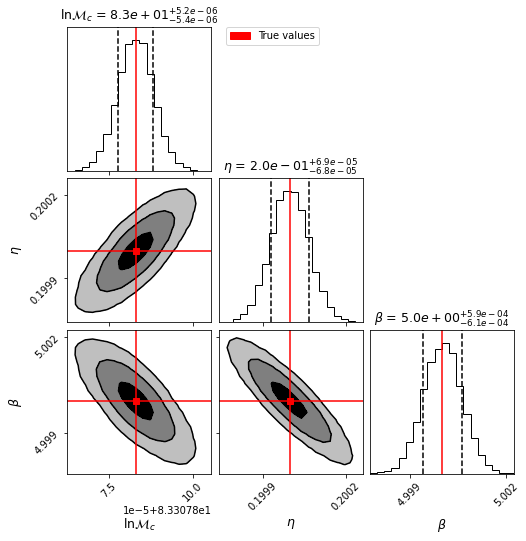

In [17]:
labels = [r'$\ln\mathcal{M}_c$', r'$\eta$', r'$\beta$']
truths=[logMchirp_true,eta_true,beta_true]

fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

red_patch = mpatches.Patch(color='red', label='True values')
plt.legend(handles=[red_patch],bbox_to_anchor=(-1., 3.1), 
           loc='upper left', borderaxespad=0.)
plt.show()